In [89]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


In [ ]:

plot_df = df['T (degC)']
plot_df.index = df['Date Time']
plot_df.plot(subplots=True)


In [ ]:
plot_df.plot(kind='kde')

In [ ]:
df_s = pd.DataFrame({'Date Time':plot_df.index, 'Temperature':plot_df.values})

df_s['Date Time'] = pd.to_datetime(df_s['Date Time'])
df_s = df_s.set_index('Date Time')
df_s.head(100)

In [ ]:
# Need to write frequency calculation
result = seasonal_decompose(df_s, freq=52560)
result.plot()
plt.show()

In [ ]:
df_s.hist()


In [ ]:
def test_stationarity(df_s):
    X = df_s.values
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    return [{'Mean-1': mean1,'Mean-2': mean2}, {'Variance-1':var1,'Variance-2':var2}]
    

In [ ]:
results = test_stationarity(df_s)
print("Simple Results:")
print("Mean for first 1/2 of data: {}, Mean for Second 1/2 of data: {}".
      format(results[0].get('Mean-1'), results[0].get('Mean-2')))
print("Variance for first 1/2 of data: {}, Mean for Second 1/2 of data: {}".
      format(results[1].get('Variance-1'), results[1].get('Variance-2')))

In [ ]:
#define function for ADF test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag =1)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


In [ ]:
data = df_s['Temperature']
data = data.values.flatten()
adf_test(data)

In [ ]:
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.tsatools import lagmat, add_trend
from statsmodels.tsa.adfvalues import mackinnonp

def adf(ts):
    """
    Augmented Dickey-Fuller unit root test
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # Get the dimension of the array
    nobs = ts.shape[0]
    
    # We use 1 as maximum lag in our calculations
    maxlag = 1
    
    # Calculate the discrete difference
    tsdiff = np.diff(ts)
    
    # Create a 2d array of lags, trim invalid observations on both sides
    tsdall = lagmat(tsdiff[:, None], maxlag, trim='both', original='in')
    # Get dimension of the array
    nobs = tsdall.shape[0] 
    
    # replace 0 xdiff with level of x
    tsdall[:, 0] = ts[-nobs - 1:-1]  
    tsdshort = tsdiff[-nobs:]
    
    # Calculate the linear regression using an ordinary least squares model    
    results = OLS(tsdshort, add_trend(tsdall[:, :maxlag + 1], 'c')).fit()
    adfstat = results.tvalues[0]
    
    # Get approx p-value from a precomputed table (from stattools)
    pvalue = mackinnonp(adfstat, 'c', N=1)
    return pvalue

In [ ]:
adf(df_s['Temperature'])

# Removing Stationarity

In [ ]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [6]:
def difference_using_shift(dataset,interval):
    return dataset - dataset.shift(interval)
    

In [8]:
def perform_seasonal_decomposition(series_data):
    series_data = series_data.dropna()
    df_s = pd.DataFrame({'Date Time':series_data.index, 'Temperature':series_data.values})
    df_s['Date Time'] = pd.to_datetime(df_s['Date Time'])
    df_s = df_s.set_index('Date Time')
    result = seasonal_decompose(df_s, freq=52560)
    result.plot()
    plt.show()

In [ ]:
# It's taking a long time for somereason
plot_df = difference(df['T (degC)'])
plot_df.index = df['Date Time'].values[1:]
perform_seasonal_decomposition(plot_df)

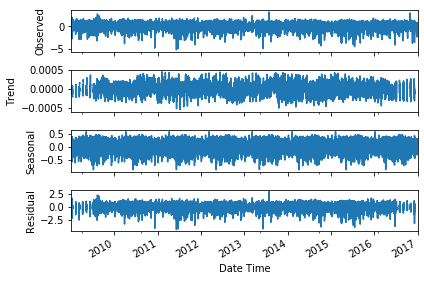

In [9]:
plot_df = difference_using_shift(df['T (degC)'],1)
plot_df.index = df['Date Time']
perform_seasonal_decomposition(plot_df)

In [10]:
TRAIN_SPLIT = 300000

In [32]:
train, test = plot_df[1:TRAIN_SPLIT], plot_df[TRAIN_SPLIT:]

In [90]:
from statsmodels.tsa.ar_model import AR
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start = len(train), end = len(train)+len(test)-1)


Lag: 89
Coefficients: const           0.000057
L1.T (degC)     0.468267
L2.T (degC)    -0.139377
L3.T (degC)     0.100761
L4.T (degC)     0.020907
                  ...   
L85.T (degC)   -0.011159
L86.T (degC)   -0.009197
L87.T (degC)   -0.010957
L88.T (degC)   -0.005366
L89.T (degC)   -0.018338
Length: 90, dtype: float64


In [91]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results

Test MSE: 0.059


In [55]:
df_p = predictions.to_frame().reset_index()

In [59]:
df_p = df_p.rename(columns={0: 'Temperature'})

In [61]:
df_p.head()

,index,Temperature
0,299999,-0.024084
1,300000,-0.032796
2,300001,-0.032598
3,300002,-0.031146
4,300003,-0.030694


In [62]:
df_t = test.to_frame().reset_index()

In [65]:
df_t = df_t.rename(columns={'T (degC)': 'Temperature'})

In [72]:
df_t['Index']= df_p['index']

In [74]:
df_t.head()

,Date Time,Temperature,Index
0,13.09.2014 02:20:00,-0.02,299999
1,13.09.2014 02:30:00,-0.05,300000
2,13.09.2014 02:40:00,0.00,300001
3,13.09.2014 02:50:00,0.00,300002
4,13.09.2014 03:00:00,0.00,300003


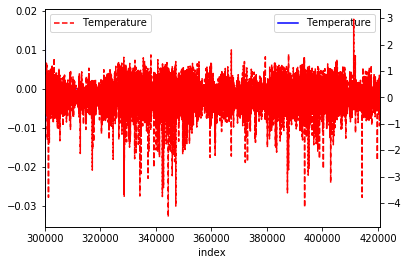

In [77]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax2 = ax.twinx()
df_p.plot(x="index", y=["Temperature"], ax=ax,color='blue')
df_t.plot(x="Index", y=["Temperature"], ax=ax2, ls="--",color='red')


ax.legend(loc=1)
ax2.legend(loc=2)

plt.show()

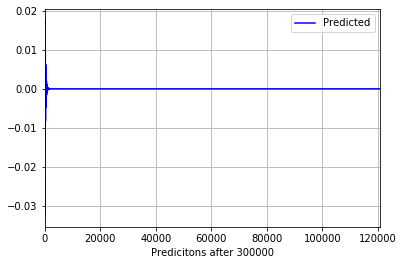

In [87]:
plt.xlabel('Predicitons after 300000')

ax1 = df_p.Temperature.plot(color='blue', grid=True, label='Predicted')
ax1.legend(loc=1)
plt.show()

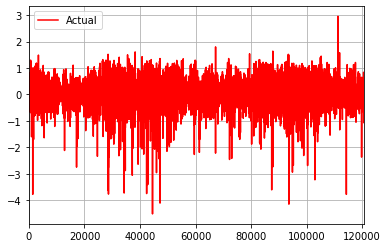

In [88]:
ax2 = df_t.Temperature.plot(color='red', grid=True, label='Actual')
ax2.legend(loc=2)
plt.show()